In [104]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Concatenate, Flatten, Dropout
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

In [105]:
def load_dataset_local():
    try:
        from db.connection_SQL import getData
        df_hist, _, _ = getData() 
        return df_hist
    except Exception as e:
        print(f"Gagal load dari DB: {e}. Mengambil dari CSV...")
        return pd.read_csv('sales_history.csv')

df_raw = load_dataset_local() 

d:\Magang\db\connection_SQL.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df1 = pd.read_sql(query1, conn)
d:\Magang\db\connection_SQL.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df2 = pd.read_sql(query2, conn)
d:\Magang\db\connection_SQL.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df3 = pd.read_sql(query3, conn)


In [106]:
df_raw['period'] = pd.to_datetime(df_raw['period'])
if 'model_reference' not in df_raw.columns:
    df_raw['model_reference'] = df_raw['model']
df_raw['model_reference'] = df_raw['model_reference'].fillna(df_raw['model'])
parent_map = df_raw.set_index('model')['model_reference'].to_dict()

def get_root_reference(model_name):
    current = model_name
    visited = set()
    while True:
        if current in visited: return current 
        visited.add(current)
        
        parent = parent_map.get(current, current)
        if parent == current:
            return current
        current = parent

df_raw['root_ref'] = df_raw['model'].apply(get_root_reference)
df_root_agg = df_raw.groupby(['period', 'branch_name', 'root_ref'])['model_qty'].sum().reset_index()
df_clean = df_raw.groupby(['period', 'branch_name', 'root_ref', 'model'])['model_qty'].sum().reset_index()

In [107]:
le_branch = LabelEncoder()
df_clean['branch_idx'] = le_branch.fit_transform(df_clean['branch_name'])
le_root = LabelEncoder() 
df_clean['root_idx'] = le_root.fit_transform(df_clean['root_ref'])
le_model = LabelEncoder()
df_clean['model_idx'] = le_model.fit_transform(df_clean['model'])
model_to_root_map = df_clean.set_index('model')['root_ref'].to_dict()

LOOK_BACK = 12
X_list, y_list = [], []
b_idx_list, r_idx_list, m_idx_list = [], [], []
weights_list = []
scalers = {}
for (b_name, r_name, m_name), group in df_clean.groupby(['branch_name', 'root_ref', 'model']):
    group = group.sort_values('period').set_index('period').resample('MS').sum().reset_index()
    
    if len(group) < 24: continue
    
    qty = group['model_qty'].values.astype(float)
    diff = qty[12:] - qty[:-12]
    
    if len(diff) <= LOOK_BACK: continue
    abs_diff = np.abs(diff)
    threshold = np.mean(abs_diff) + (0.5 * np.std(abs_diff))
    
    sc = StandardScaler()
    diff_scaled = sc.fit_transform(diff.reshape(-1, 1)).flatten()
    scalers[(b_name, m_name)] = sc
    b_id = le_branch.transform([b_name])[0]
    r_id = le_root.transform([r_name])[0] 
    m_id = le_model.transform([m_name])[0]
    
    for i in range(len(diff_scaled) - LOOK_BACK):
        X_list.append(diff_scaled[i:i+LOOK_BACK])
        y_list.append(diff_scaled[i+LOOK_BACK])
        b_idx_list.append(b_id)
        r_idx_list.append(r_id) 
        m_idx_list.append(m_id)
        
        if abs(diff[i+LOOK_BACK]) > threshold:
            weights_list.append(5.0)
        else:
            weights_list.append(1.0)

X = np.array(X_list).reshape(-1, LOOK_BACK, 1)
y = np.array(y_list)

b_idx = np.array(b_idx_list)
r_idx = np.array(r_idx_list)
m_idx = np.array(m_idx_list)
sample_weights = np.array(weights_list)


In [ ]:
input_seq = Input(shape=(LOOK_BACK, 1), name='seq_in')
input_branch = Input(shape=(1,), name='branch_in')
input_root = Input(shape=(1,), name='root_in') # Input Reference
input_model = Input(shape=(1,), name='model_in')

x = LSTM(64, return_sequences=True)(input_seq)
x = Dropout(0.2)(x)
x = LSTM(32)(x)
x = Dropout(0.2)(x)
emb_branch = Flatten()(Embedding(len(le_branch.classes_) + 1, 8)(input_branch))
emb_root = Flatten()(Embedding(len(le_root.classes_) + 1, 8)(input_root))
emb_model = Flatten()(Embedding(len(le_model.classes_) + 1, 8)(input_model))

concat = Concatenate()([x, emb_branch, emb_root, emb_model])
x_dense = Dense(32, activation='relu')(concat)
out = Dense(1)(x_dense)

model = Model(inputs=[input_seq, input_branch, input_root, input_model], outputs=out)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
model.fit(
    [X, b_idx, r_idx, m_idx], y, 
    sample_weight=sample_weights,
    epochs=100, 
    batch_size=16, 
    validation_split=0.15,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Save
model.save('global_root_model.keras')
metadata = {
    'scalers': scalers,
    'le_branch': le_branch,
    'le_root': le_root, 
    'le_model': le_model,
    'model_to_root_map': model_to_root_map,
    'lookback': LOOK_BACK
}
with open('model_metadata.pkl', 'wb') as f:
    pickle.dump(metadata, f)
print("Model & Metadata tersimpan.")

Epoch 1/100
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - loss: 2.8524 - val_loss: 2.0076 - learning_rate: 0.0010
Epoch 2/100
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 2.3194 - val_loss: 1.9026 - learning_rate: 0.0010
Epoch 3/100
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 2.2080 - val_loss: 1.8849 - learning_rate: 0.0010
Epoch 4/100
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 2.1661 - val_loss: 1.9141 - learning_rate: 0.0010
Epoch 5/100
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 2.1569 - val_loss: 1.8561 - learning_rate: 0.0010
Epoch 6/100
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 2.1345 - val_loss: 1.8338 - learning_rate: 0.0010
Epoch 7/100
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 2.1169 - val_loss: 1.8572 - learning_rate: 0.0010
Epoch 8/100
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 2.1197 - val_loss: 1.8241 - learning_rate: 0.0010
Epoch 9/100
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 2.1007 - val_lo

In [109]:
print(f"Jumlah baris data training: {len(X)}")
print(f"Variansi data target (y): {np.var(y)}")
# Jika variansi mendekati 0, pantas saja modelnya datar.

Jumlah baris data training: 20113
Variansi data target (y): 0.9929349044431085


In [110]:
def get_latest_diff_sequence(b_name, m_name, df_clean, scalers, lookback=12):
    if (b_name, m_name) not in scalers:
        return None, None
    subset = df_clean[(df_clean['branch_name'] == b_name) & 
                      (df_clean['model'] == m_name)].sort_values('period')
    
    act_2025 = subset[subset['period'].dt.year == 2025]['model_qty'].values
    act_2024 = subset[subset['period'].dt.year == 2024]['model_qty'].values
    if len(act_2025) < 12 or len(act_2024) < 12:
        return None, None

    diff = (act_2025 - act_2024).astype(float)
    diff_scaled = scalers[(b_name, m_name)].transform(diff.reshape(-1, 1))
    return diff_scaled[-lookback:].reshape(1, lookback, 1), act_2025

def forecast_2026_smart(model, b_name, m_name, df_clean, le_branch, le_root, le_model, scalers, root_map):

    seq_in, last_year_actual = get_latest_diff_sequence(b_name, m_name, df_clean, scalers)
    if seq_in is None: return None
    b_idx_in = np.array([le_branch.transform([b_name])[0]])
    r_name = root_map.get(m_name, m_name) 
    try:
        r_idx_in = np.array([le_root.transform([r_name])[0]])
    except:
        r_idx_in = np.array([0])
    m_idx_in = np.array([le_model.transform([m_name])[0]])
    pred_diff_scaled = model.predict([seq_in, b_idx_in, r_idx_in, m_idx_in], verbose=0)
    pred_diff_actual = scalers[(b_name, m_name)].inverse_transform(pred_diff_scaled).flatten()[0]
    jan_2025 = last_year_actual[0] 
    pred_jan_2026 = max(0, jan_2025 + pred_diff_actual)
    
    return round(pred_jan_2026)

In [111]:
def get_root_history(b_name, r_name, year, df_root):
    subset = df_root[
        (df_root['branch_name'] == b_name) & 
        (df_root['root_ref'] == r_name) & 
        (df_root['period'].dt.year == year)
    ].sort_values('period')
    
    if len(subset) == 12:
        return subset['model_qty'].values.astype(float)
    return None

In [112]:
def evaluate_branch_performance_smart(df_clean, df_root_agg, model, scalers, le_branch, le_root, le_model, root_map):
    results = []
    for (b_name, m_name) in scalers.keys():
        subset = df_clean[(df_clean['branch_name'] == b_name) & 
                          (df_clean['model'] == m_name)].sort_values('period')
        
        act_2025 = subset[subset['period'].dt.year == 2025]['model_qty'].values
        if len(act_2025) < 12: continue 

        act_2024 = subset[subset['period'].dt.year == 2024]['model_qty'].values
        act_2023 = subset[subset['period'].dt.year == 2023]['model_qty'].values
        
        diff_input = None
        if len(act_2023) == 12 and len(act_2024) == 12:
            diff_input = (act_2024 - act_2023)
        else:
            r_name = root_map.get(m_name, m_name)
            root_2023 = get_root_history(b_name, r_name, 2023, df_root_agg)
            root_2024 = get_root_history(b_name, r_name, 2024, df_root_agg)
            
            if root_2023 is not None and root_2024 is not None:
                diff_root = (root_2024 - root_2023)
                vol_root_24 = np.sum(root_2024)
                vol_model_24 = np.sum(act_2024) if len(act_2024)==12 else np.sum(act_2025) # Fallback ke 2025
                
                ratio = 0
                if vol_root_24 > 0:
                    ratio = vol_model_24 / vol_root_24
                diff_input = diff_root * ratio

        if diff_input is None: continue
        try:
            curr_batch = scalers[(b_name, m_name)].transform(diff_input.reshape(-1, 1)).reshape(1, 12, 1)
        except:
            continue 
        b_in = np.array([le_branch.transform([b_name])[0]])
        r_name = root_map.get(m_name, m_name)
        try: r_in = np.array([le_root.transform([r_name])[0]])
        except: r_in = np.array([0])
        m_in = np.array([le_model.transform([m_name])[0]])
        
        preds_2025 = []
        last_val = act_2024[-1] if len(act_2024) > 0 else (act_2025[0] if len(act_2025)>0 else 0)
        current_lvl = last_val
        
        for i in range(12):
            p_sc = model.predict([curr_batch, b_in, r_in, m_in], verbose=0)
            p_val = scalers[(b_name, m_name)].inverse_transform(p_sc).flatten()[0]
            
            # Rekonstruksi
            if len(act_2024) == 12:
                final_val = max(0, act_2024[i] + p_val)
            else:
                final_val = max(0, current_lvl + p_val)
                current_lvl = final_val 
                
            preds_2025.append(final_val)
            
            new_in = p_sc.reshape(1, 1, 1)
            curr_batch = np.append(curr_batch[:, 1:, :], new_in, axis=1)
        mae = mean_absolute_error(act_2025, preds_2025)
        total_act = np.sum(act_2025)
        total_pred = np.sum(preds_2025)
        acc = max(0, 100 * (1 - abs(total_act - total_pred)/total_act)) if total_act > 0 else 0
        
        results.append({
            'Branch': b_name, 'Model': m_name, 
            'Akurasi (%)': round(acc, 2), 'MAE': round(mae, 2)
        })
        
    return pd.DataFrame(results)

In [113]:
def forecast_full_year_2026(b_name, m_name, df_clean, model, scalers, le_branch, le_root, le_model, root_map):
    if (b_name, m_name) not in scalers: return None
    
    subset = df_clean[(df_clean['branch_name'] == b_name) & 
                      (df_clean['model'] == m_name)].sort_values('period')
    
    act_2025 = subset[subset['period'].dt.year == 2025]['model_qty'].values
    act_2024 = subset[subset['period'].dt.year == 2024]['model_qty'].values
    
    if len(act_2025) < 12 or len(act_2024) < 12: return None

    diff_2025 = (act_2025 - act_2024).reshape(-1, 1)
    
    curr_batch = scalers[(b_name, m_name)].transform(diff_2025).reshape(1, 12, 1)
    
    b_in = np.array([le_branch.transform([b_name])[0]])
    r_name = root_map.get(m_name, m_name)
    try: r_in = np.array([le_root.transform([r_name])[0]])
    except: r_in = np.array([0])
    m_in = np.array([le_model.transform([m_name])[0]])
    
    forecasts = []
    for i in range(12):
        pred_scaled = model.predict([curr_batch, b_in, r_in, m_in], verbose=0)
        pred_val = scalers[(b_name, m_name)].inverse_transform(pred_scaled).flatten()[0]
        final_val = max(0, act_2025[i] + pred_val)
        forecasts.append(int(round(final_val)))
        
        new_in = pred_scaled.reshape(1, 1, 1)
        curr_batch = np.append(curr_batch[:, 1:, :], new_in, axis=1)
        
    return forecasts

In [114]:
df_eval = evaluate_branch_performance_smart(
    df_clean, df_root_agg, model, scalers, 
    le_branch, le_root, le_model, model_to_root_map
)

months = ['Jan', 'Feb', 'Mar', 'Apr', 'Mei', 'Jun', 'Jul', 'Agu', 'Sep', 'Okt', 'Nov', 'Des']
final_dashboard = []
for (b_name, m_name) in scalers.keys():
    forecasts = forecast_full_year_2026(
        b_name, m_name, df_clean, model, scalers, 
        le_branch, le_root, le_model, model_to_root_map
    )
    
    if forecasts is None: continue
    eval_row = df_eval[(df_eval['Branch'] == b_name) & (df_eval['Model'] == m_name)]
    acc_val = eval_row['Akurasi (%)'].values[0] if not eval_row.empty else 0
    mae_val = eval_row['MAE'].values[0] if not eval_row.empty else 0
    
    ref_name = model_to_root_map.get(m_name, "-")

    row_data = {
        'Branch': b_name, 
        'Model AC': m_name,
        'Model Reference': ref_name,
        'Akurasi (%)': acc_val, 
        'MAE': mae_val,
        'Total 2026': sum(forecasts)
    }
    
    for i, mon in enumerate(months):
        row_data[mon] = forecasts[i]
        
    final_dashboard.append(row_data)

df_final_report = pd.DataFrame(final_dashboard).sort_values(['Branch', 'Total 2026'], ascending=[True, False])
pd.set_option('display.float_format', '{:.2f}'.format)
display(df_final_report.head(20))

,Branch,Model AC,Model Reference,Akurasi (%),MAE,Total 2026,Jan,Feb,Mar,Apr,Mei,Jun,Jul,Agu,Sep,Okt,Nov,Des
0,Bali,AC-CAS20-V2,AC-CAS20-V1,0.00,1014.40,16199,1549,1707,1589,1788,1008,1092,1343,1109,1522,0,1671,1821
4,Bali,AC-STD05-V3,AC-STD05-V1,5.13,899.90,14168,1587,1459,1448,1351,1004,0,1479,0,912,2276,1175,1477
8,Bali,BL-HVY-V2,BL-HVY-V1,0.00,734.98,13700,1014,1204,1269,1328,1350,1085,943,1189,1250,799,1106,1163
6,Bali,AC-STD10-V1,AC-STD10-V1,0.00,723.20,12492,1080,1133,991,1029,1033,1005,770,1102,1016,1200,1291,842
5,Bali,AC-STD05-V4,AC-STD05-V1,0.00,1044.72,12079,831,1279,1481,1101,1305,1242,1232,1159,1101,611,0,737
1,Bali,AC-INV10-V2,AC-INV10-V1,0.00,650.98,9916,1091,1113,945,1096,620,0,959,1251,767,997,936,141
2,Bali,AC-INV10-V3,AC-INV10-V1,7.86,758.81,9602,769,757,953,1225,855,706,756,675,0,882,1175,849
7,Bali,AC-STD10-V2,AC-STD10-V1,0.00,538.89,9365,957,750,654,689,0,165,1190,909,899,1039,1142,971
3,Bali,AC-PORT-V1,AC-PORT-V1,53.96,511.90,8721,144,524,745,790,929,674,1243,704,424,429,1021,1094
10,Balikpapan,AC-LOW05-V1,AC-LOW05-V1,0.00,818.19,13787,1536,1353,1261,1413,980,1361,1125,742,866,337,1431,1382


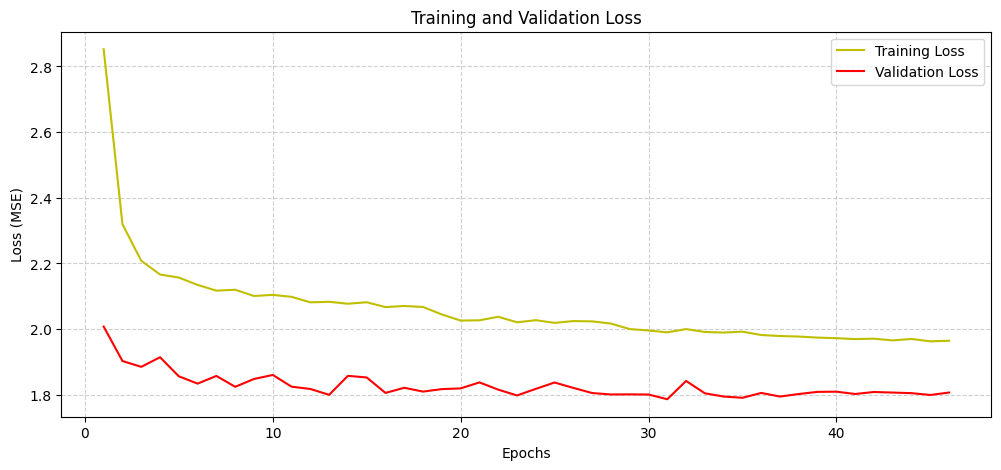

In [115]:
def plot_learning_curve(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(12, 5))
    plt.plot(epochs, loss, 'y', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    
    plt.show()

try:
    plot_learning_curve(model.history) # Jika history object
except:
    try:
        plot_learning_curve(model) # Jika dictionary langsung
    except:
        print(" Variabel 'history' tidak ditemukan. Pastikan kamu sudah run: history = model.fit(...)")

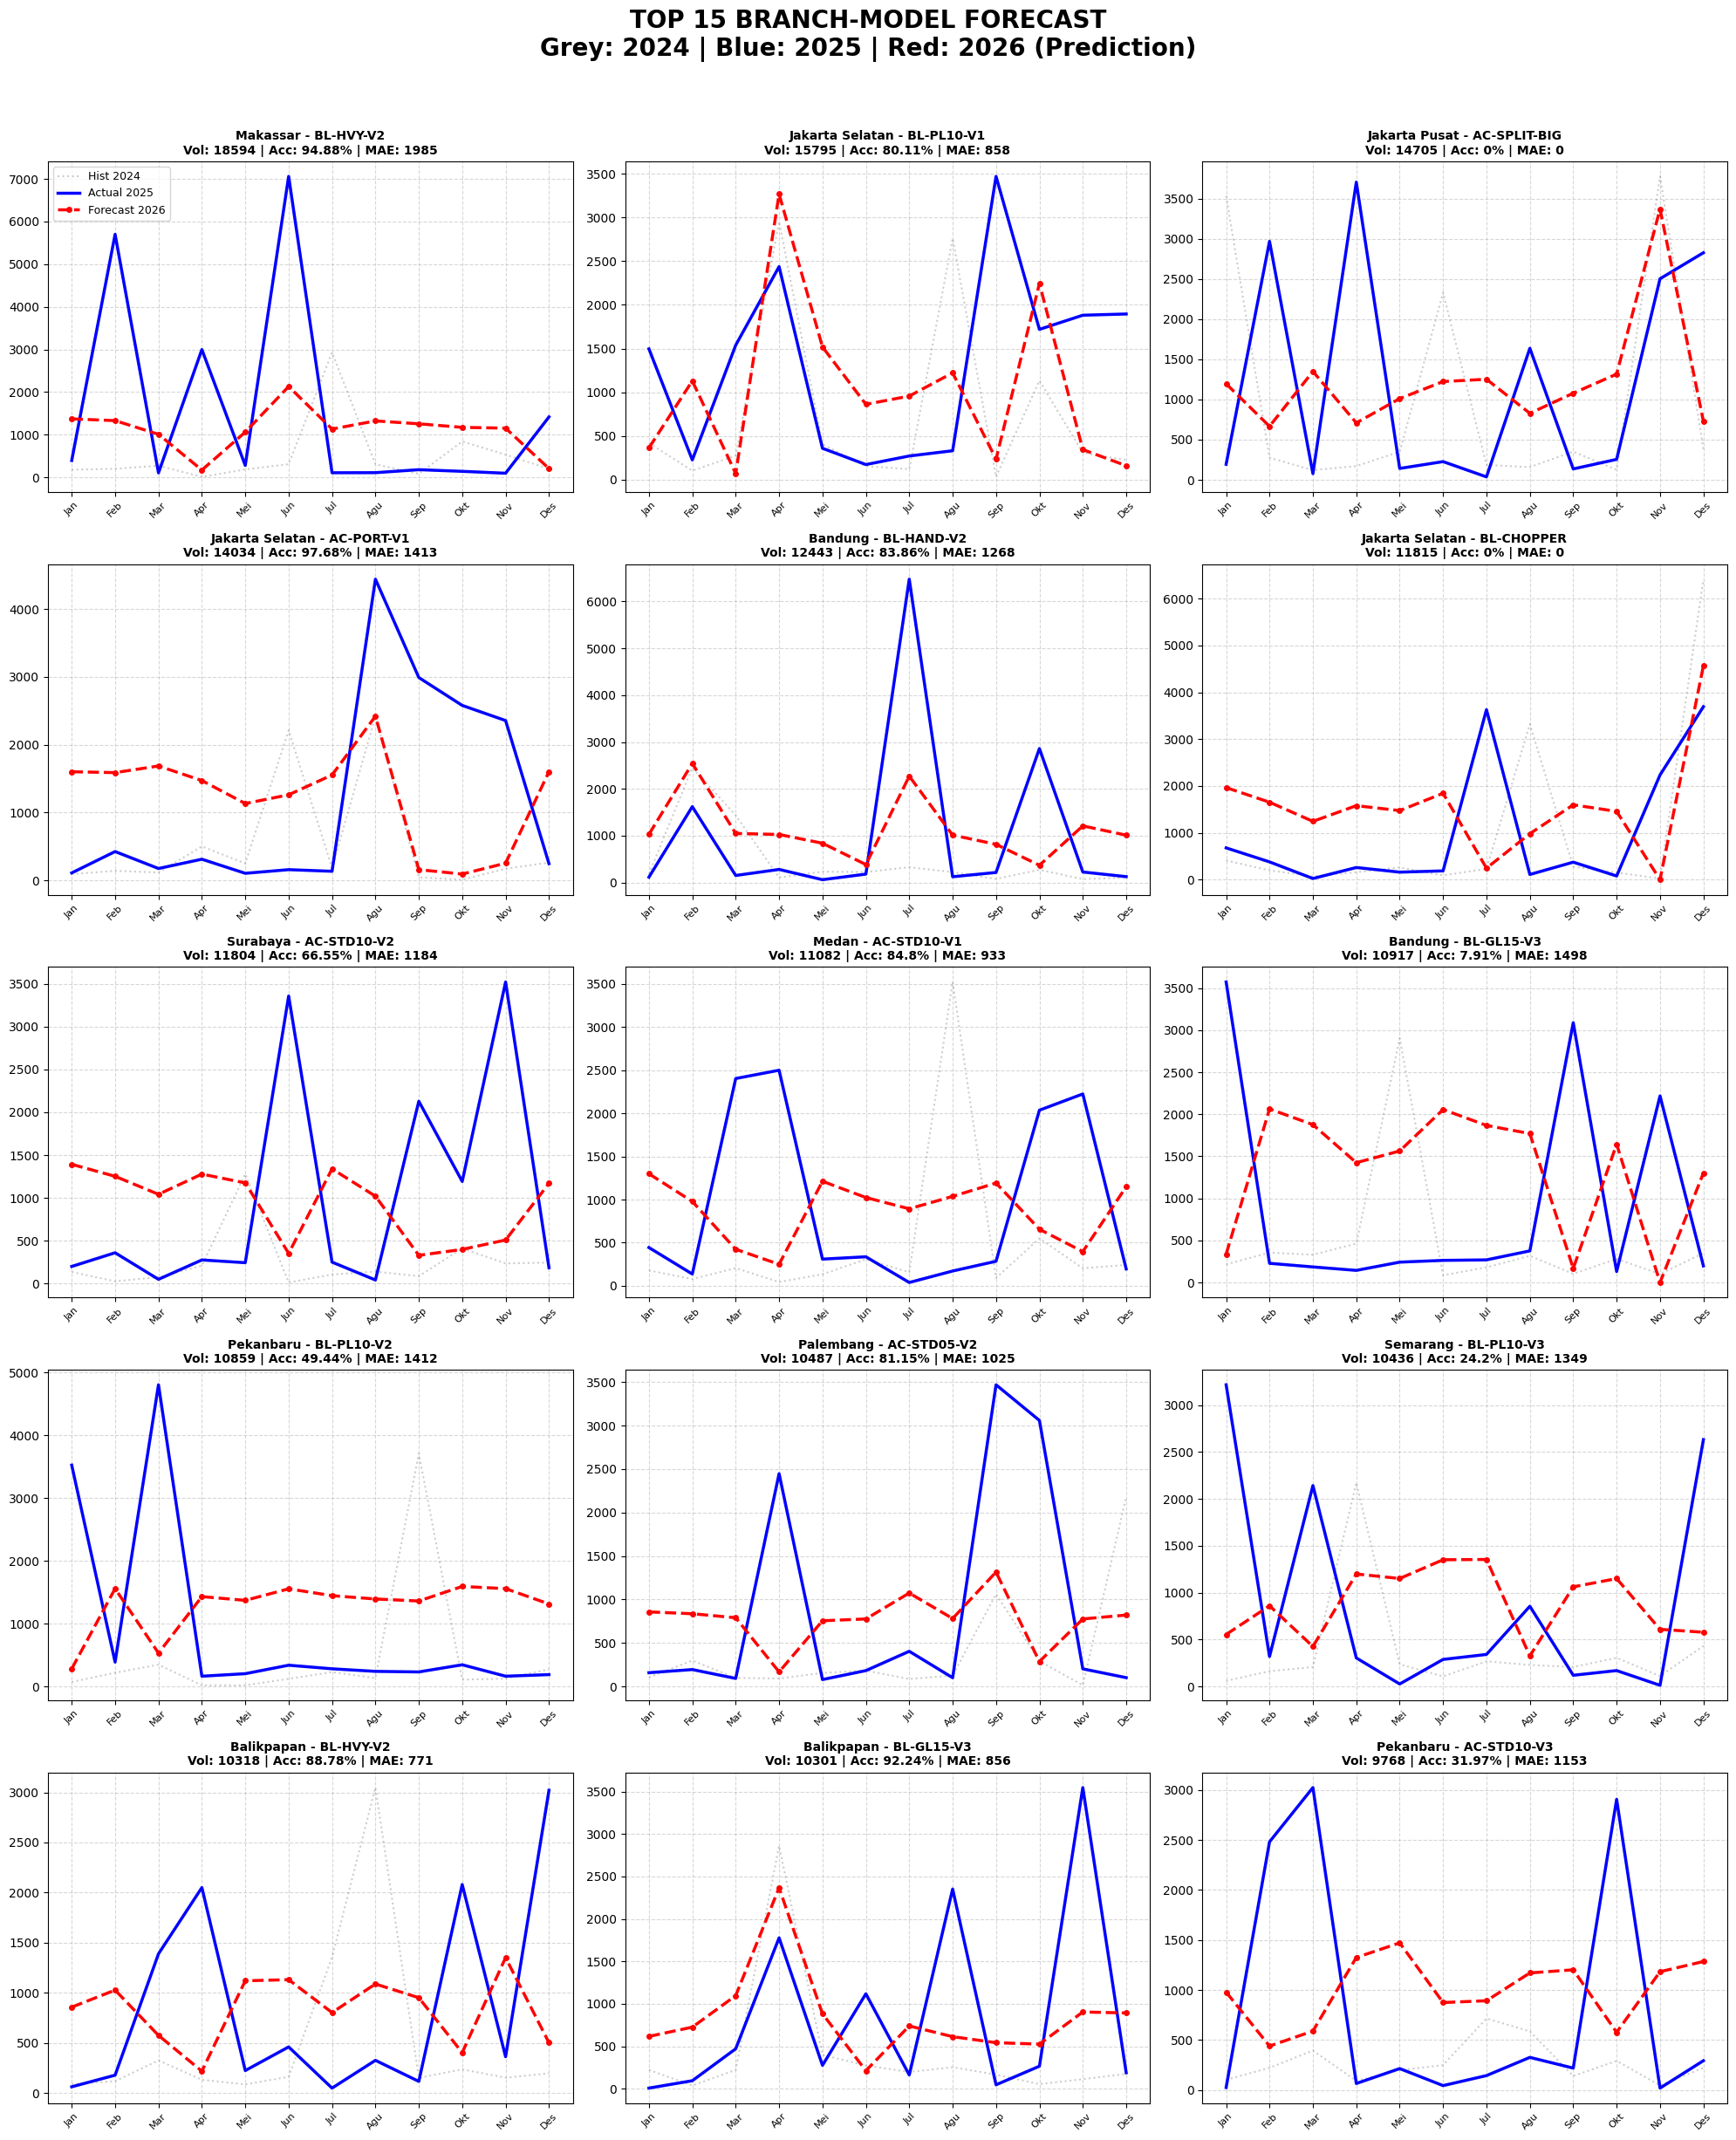

In [116]:
import matplotlib.pyplot as plt
import math
plot_data_store = []
months = ['Jan','Feb','Mar','Apr','Mei','Jun','Jul','Agu','Sep','Okt','Nov','Des']
for (b_name, m_name) in scalers.keys():
    subset = df_clean[(df_clean['branch_name'] == b_name) & 
                      (df_clean['model'] == m_name)].sort_values('period')
    
    act_2024 = subset[subset['period'].dt.year == 2024]['model_qty'].values
    act_2025 = subset[subset['period'].dt.year == 2025]['model_qty'].values
    if len(act_2025) < 12: continue
    f2026 = forecast_full_year_2026(
        b_name, m_name, df_clean, model, scalers, 
        le_branch, le_root, le_model, model_to_root_map
    )
    
    if f2026 is None: continue
    total_vol = np.sum(act_2025)
    eval_row = df_eval[(df_eval['Branch'] == b_name) & (df_eval['Model'] == m_name)]
    acc_label = eval_row['Akurasi (%)'].values[0] if not eval_row.empty else 0
    mae_label = eval_row['MAE'].values[0] if not eval_row.empty else 0

    plot_data_store.append({
        'branch': b_name,
        'model': m_name,
        'act_2024': act_2024 if len(act_2024)==12 else [0]*12, # Fallback 0 jika kosong
        'act_2025': act_2025,
        'f_2026': f2026,
        'total_vol': total_vol,
        'acc': acc_label,
        'mae': mae_label
    })

plot_data_store.sort(key=lambda x: x['total_vol'], reverse=True)
rows = 5  
cols = 3  
total_plots = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(20, 24)) # Ukuran Gambar Besar
axes = axes.flatten()
for i, ax in enumerate(axes):
    if i < len(plot_data_store):
        d = plot_data_store[i]
        ax.plot(months, d['act_2024'], color='gray', alpha=0.4, linewidth=1.5, linestyle=':', label='Hist 2024')
        ax.plot(months, d['act_2025'], color='blue', linewidth=2.5, label='Actual 2025')
        ax.plot(months, d['f_2026'], color='red', linestyle='--', linewidth=2.5, marker='o', markersize=4, label='Forecast 2026')
        ax.set_title(
            f"{d['branch']} - {d['model']}\nVol: {int(d['total_vol'])} | Acc: {d['acc']}% | MAE: {d['mae']:.0f}",
            fontsize=10, fontweight='bold'
        )
        
        ax.tick_params(axis='x', rotation=45, labelsize=8)
        ax.grid(True, linestyle='--', alpha=0.5)
        if i == 0:
            ax.legend(loc='upper left', fontsize=9, frameon=True)
            
    else:
        ax.axis('off')

# Judul Utama
plt.suptitle(
    f"TOP {total_plots} BRANCH-MODEL FORECAST\n"
    f"Grey: 2024 | Blue: 2025 | Red: 2026 (Prediction)",
    fontsize=20, fontweight='bold', y=1.02
)

plt.tight_layout()
plt.show()

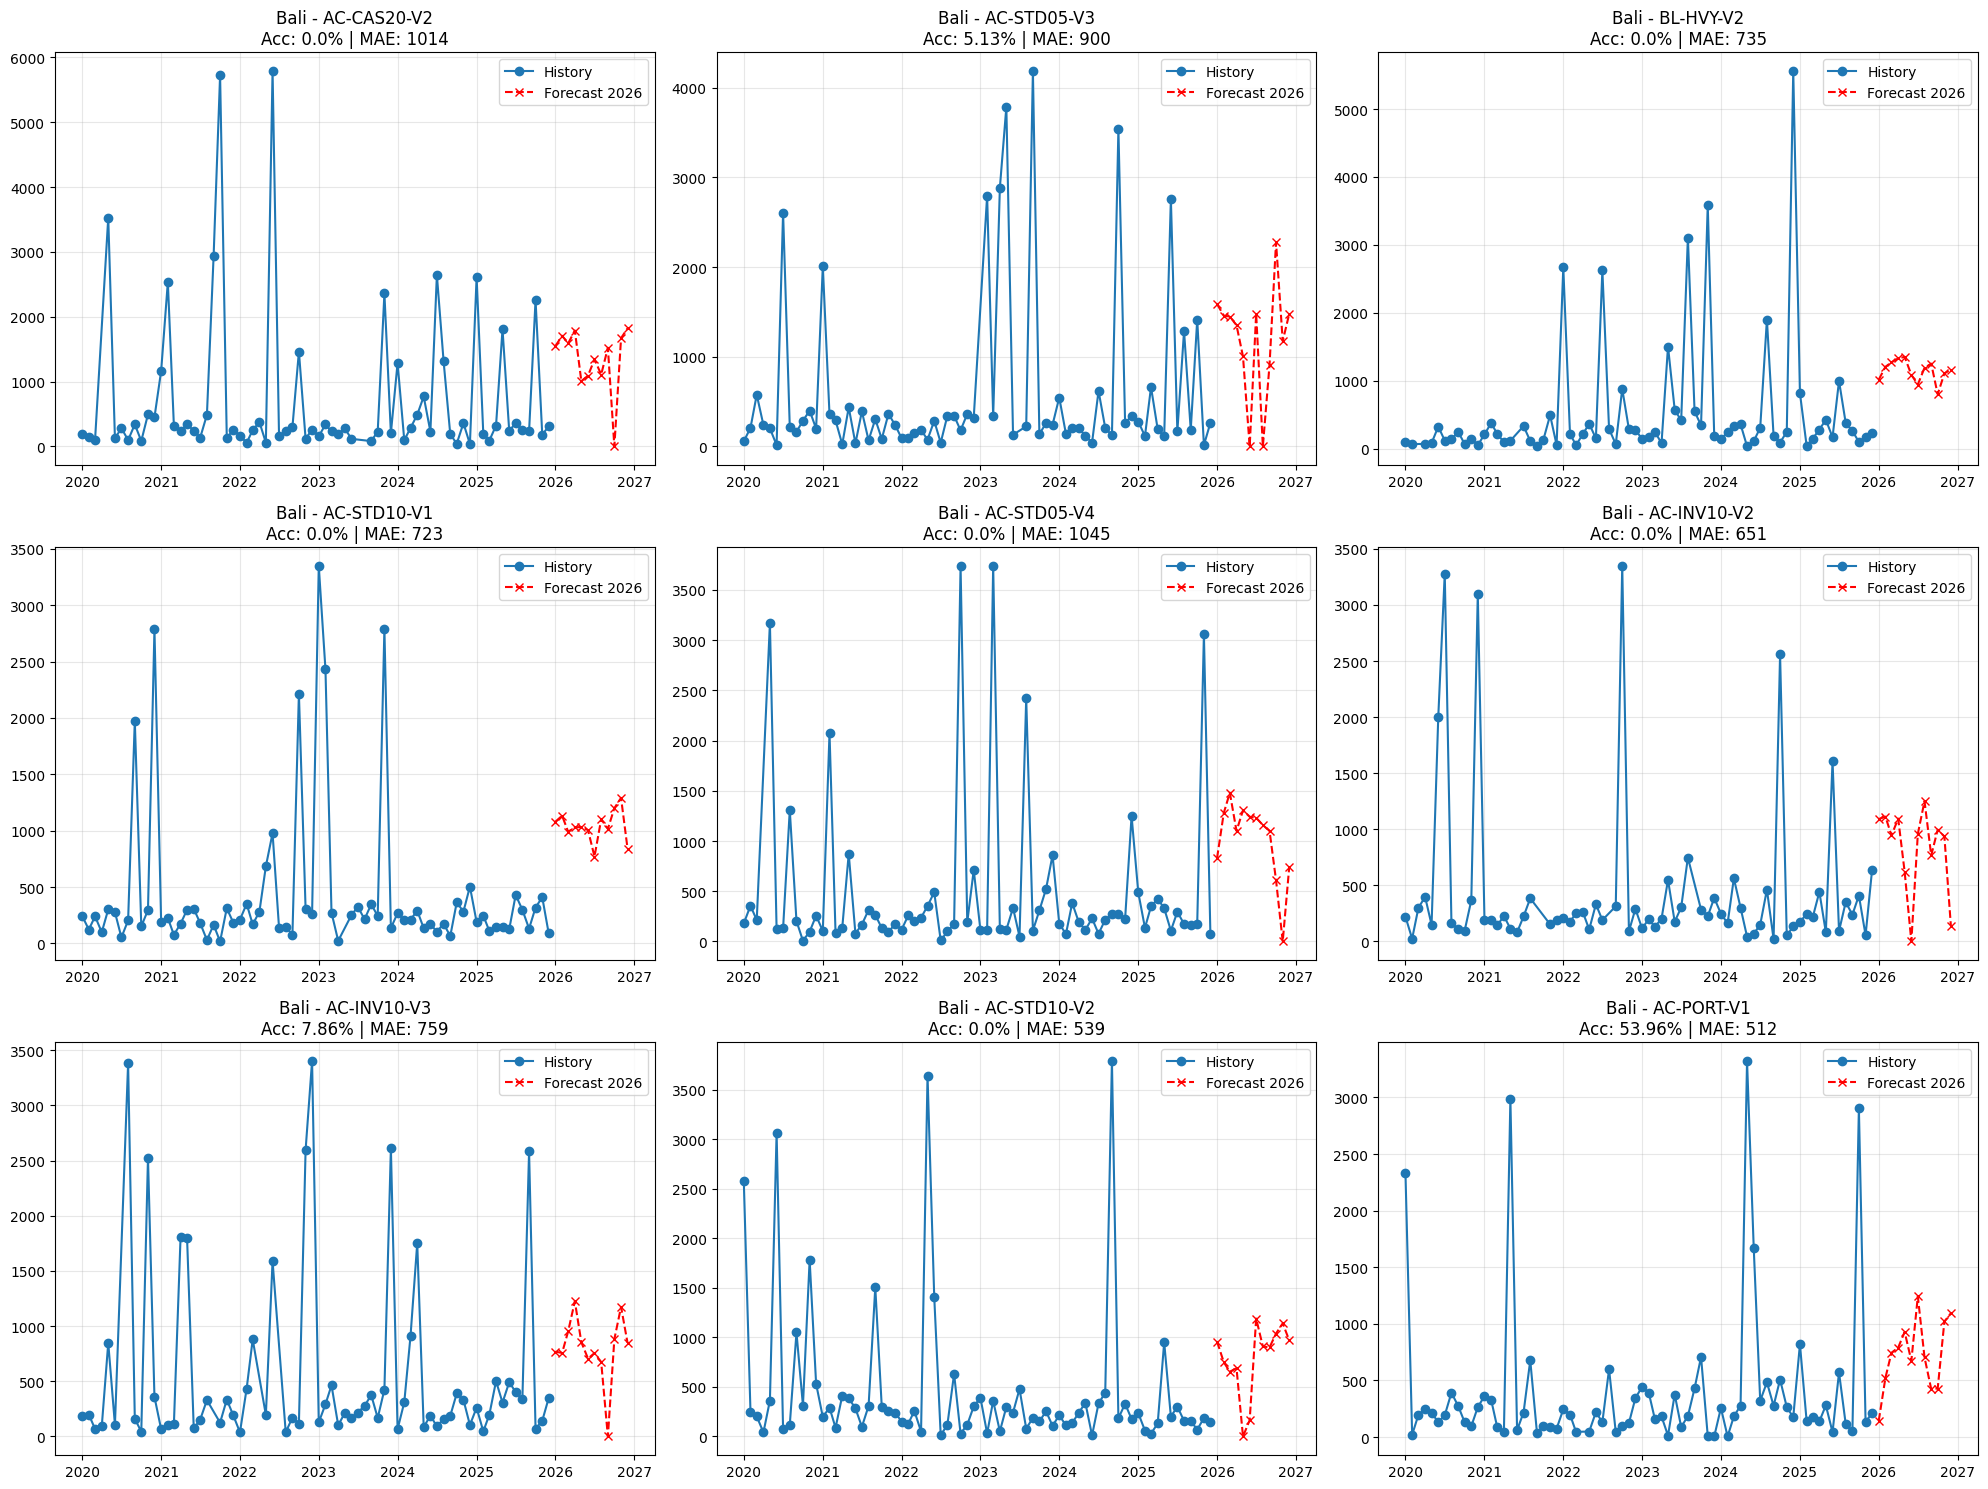

In [117]:
top_models = df_final_report.head(9)
rows, cols = 3, 3
fig, axes = plt.subplots(rows, cols, figsize=(20, 15))
axes = axes.flatten()

for i, (idx, row) in enumerate(top_models.iterrows()):
    if i >= len(axes): break
    
    b_name = row['Branch']
    m_name = row['Model AC']
    subset = df_clean[(df_clean['branch_name'] == b_name) & 
                      (df_clean['model'] == m_name)].sort_values('period')
    
    dates = subset['period']
    act_qty = subset['model_qty']
    
    ax = axes[i]
    ax.plot(dates, act_qty, label='History', marker='o')
    dates_2026 = pd.date_range(start='2026-01-01', periods=12, freq='MS')
    forecast_vals = [row[m] for m in months]
    
    ax.plot(dates_2026, forecast_vals, label='Forecast 2026', linestyle='--', color='red', marker='x')
    
    ax.set_title(f"{b_name} - {m_name}\nAcc: {row['Akurasi (%)']}% | MAE: {row['MAE']:.0f}")
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### Save model

In [118]:
# import pickle
# model.save('global_seasonal_model.keras')
# print("Model .keras berhasil disimpan!")
# metadata = {
#     'scalers': scalers,
#     'le_model': le_model,
#     'lookback': LOOK_BACK
# }

# with open('model_metadata.pkl', 'wb') as f:
#     pickle.dump(metadata, f)

# print("Metadata (Scalers & Encoder) berhasil disimpan!")